# ML lab 06a - Demo on Bayesian Learning in the context of linear regression

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.precision', 3)
np.set_printoptions(precision=3)

sns.set_theme(style="dark")

In [3]:
import warnings
warnings.filterwarnings('ignore')

Fix the random number generator so the experiment is reproducible

In [4]:
np.random.seed(123)

xmin, xmax = -2, +2   # interval where data is sampled from

We will approximate the linear function $3 x + 2$ over the interval [-2, 2]

In [5]:
def feval(x):
    return 3*x + 2

def fgen(N, sigma):
    x = np.random.uniform(xmin, xmax, N)
    t = feval(x) + np.random.normal(loc=0, scale=sigma, size=N)  
    return x, t

## Generate training dataset..

We generate a sample of 10 examples assuming standard gaussian noise $N(0,3^2)$

In [6]:
N = 5
sigma = 3
x,t = fgen(N, sigma)
data = pd.DataFrame({'input':x, 'target':t})

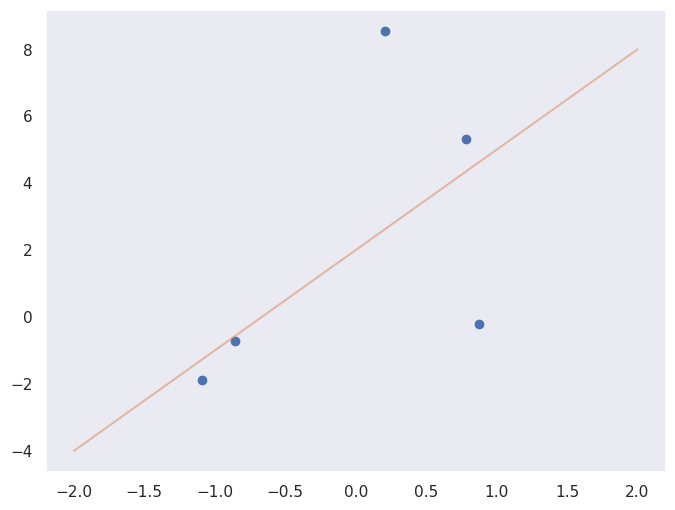

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data.input, data.target, 'o')
ax.plot(np.linspace(xmin, xmax, num=2), feval(np.linspace(xmin, xmax, num=2)), alpha=0.5);

In [8]:
X = data.input.to_numpy().reshape(N, 1)
y = data.target.to_numpy()

attr0 = np.ones((N,1))
X = np.hstack((attr0, X))

print(f'X has shape {X.shape}, y has shape {y.shape}')

X has shape (5, 2), y has shape (5,)


---
## Bayesian linear regression, a reminder

Just as a reminder, we describe the regression problem: we are given a sample 
$D = \{(\mathbf{x}_1,y_1), \dots, (\mathbf{x}_n, y_n)\}$ with $\mathbf{x}_i\in\mathbb{R}^d$ and $y_i\in\mathbb{R}$.

So: $X = \begin{pmatrix} \rule[.5ex]{2em}{0.3pt} &  \mathbf{x}_1^T & \rule[.5ex]{2em}{0.3pt}\\ & \vdots & \\ \rule[.5ex]{2em}{0.3pt} & \mathbf{x}_n^T & \rule[.5ex]{2em}{0.3pt} \end{pmatrix}$ and $\mathbf{y} = \begin{pmatrix} y_1 \\ \vdots \\ y_n\end{pmatrix}$.

We assume 

- $Y_1,\dots,Y_n$ are independent given $\theta$,  
- $Y_i\sim {\cal N}(\mathbf{x}_i^T\theta, a^{-1})$, with $a>0$ being the
precision of the noise in the observations (so, $a = \frac{1}{\sigma^2}$)
- **parameter's prior** $p(\theta) \sim {\cal N}(0, b^{-1}I)$ with $b>0$, i.e., spherical or isotropic Gaussian
- $a,b$ known
- the only parameter variables are the coefficients $\theta=(\theta_0,\dots,\theta_d)^T$

### Likelihood:  $p(D | \theta) \sim {\cal N}(X\theta, a^{-1}I)$

So: $p(D | \theta) \propto \exp\left\{ -\frac{a}{2}(\mathbf{y} - X\theta)^T (\mathbf{y} - X\theta) \right\}$


### Posterior:  $p(\theta | D) \sim {\cal N}(\mu, Q^{-1})$, where

- $Q = a X^T X + bI$
- $\mu = a Q^{-1} X^T \mathbf{y}$

### 
Predictive posterior: $p(y_{\star}|x_{\star},D) \sim {\cal N}(m, s^{-1})$

- $m = \mathbf{x}_{\star}^T \mu$
- $\frac{1}{s} = \frac{1}{a} + \mathbf{x}_{\star}^T Q \mathbf{x}_{\star}$, where

- $\mu =  (X^T X + \frac{b}{a} I)^{-1} X^T \mathbf{y}$ is the mean of the posterior distribution $p(\theta | D)$
- $Q$ is the precision matrix of the posterior distribution


---
## Computation of posterior as new data becomes available sequentially, one by one

Assume initial isotropic prior with precision $b$. In what follows, we are going to compute a sequence
of posterior distributions, as new data points are revealed. 

Initially the prior is $p(\theta) \sim {\cal N}(0, b^{-1}I)$ with $b>0$. For convenience we use _precision matrices_  instead of covariance matrices
to describe the Gaussians that constitute posterior distributions (precision matrices, which we call $Q$ here, are the inverses of the covariance matrices). 

So, $Q_0$ is the precision matrix of the prior which 
corresponds to the isotropic Gaussian prior to seing any data. Then, $Q_i$ will be the precision matrix of the posterior after 
seeing the first $i$ input-output pairs (observations) in the data, namely:

$$p(\theta | \{(\mathbf{x}_1, y_1),\cdots,(\mathbf{x}_i, y_i)\}) \sim {\cal N}(\mathbf{\mu}_i, Q_i^{-1})$$

After one iteration (i=1), the posterior corresponds to $p(\theta | \{(x_1, y_1)\}) \sim {\cal N}(\mathbf{\mu}_1, Q_1^{-1})$ and is given by 

- $Q_1 = a \mathbf{x}_1^T \mathbf{x}_1  + bI$    $~~~~$     (please note $\mathbf{x}_1^T \mathbf{x}_1$ is an _outer product_)
- $\mathbf{\mu}_1 = a Q_1^{-1} \mathbf{x}_1^T y_1$

After two iterations (i=2), the posterior corresponds to $p(\theta | \{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2)\}) \sim {\cal N}(\mathbf{\mu}_2, Q_2^{-1})$ and is given by 

- $Q_2 = a (\mathbf{x}_1^T \mathbf{x}_1 + \mathbf{x}_2^T \mathbf{x}_2) + bI$ 
- $\mathbf{\mu}_1 = a Q_1^{-1} (\mathbf{x}_1^T y_1 + \mathbf{x}_2^T y_2)$

etc.

To see the validity of this, it helps to note that $X^T X$ can be expressed as a sum of outer products:

- $X^T X = \mathbf{x}_1^T \mathbf{x}_1 + \cdots + \mathbf{x}_n^T \mathbf{x}_n = \sum_{i=1}^n \mathbf{x}_i^T \mathbf{x}_i$

and similarly $X^T y$ can be expressed as a sum as well, this time of vectors:

- $X^T y = \mathbf{x}_1^T y_1 + \cdots + \mathbf{x}_n^T y_n = \sum_{i=1}^n \mathbf{x}_i^T y_i$

Note that after having seen $i$ examples, the definition of $Q_i$ and $\mathbf{\mu}_i$ are:

- $Q_i = a \mathbf{X}_{1:i}^T \mathbf{X}_{1:i}  + bI$ 
- $\mathbf{\mu}_i = a Q_i^{-1} \mathbf{X}_{1:i}^T y_{1:i}$

Which suggests the _recursive definition_ for consecutive $Q_i, \mathbf{\mu}_i$ (for $i\in\{1,\cdots,n\}$)
to make code clearer:

- $Q_0 = b I$
- $\mathbf{\mu}_0 = (0\ 0)^T$
- $Q_{i} = Q_{i-1} + a\ \mathbf{x}_i^T \mathbf{x}_i$ 
- $\mathbf{\mu}_{i} = a Q_i^{-1} (\sum_{i=1}^i \mathbf{x}_i^T y_i)$


In [10]:
a = 1/(sigma**2)   # noise for likelihood
b = 1/10   # prior's precision for isotropic Gaussian

mu_prior = np.zeros(2)
Q_prior = b * np.identity(2)

posterior_sequence = [(mu_prior, Q_prior)]   # stores sequence of consecutive posteriors

XTy = np.zeros(2)

for i in range(1, X.shape[0]+1):
    xi = X[i-1,:]    # i'th example
    yi = y[i-1]      # target value of i'th sample
    
    XTy += xi.T * yi  # add value of i'th example to update X^T y

    Q_post = Q_prior + a * np.outer(xi, xi)
    mu_post = a * np.linalg.inv(Q_post) @ XTy

    posterior_sequence.append((mu_post, Q_post))     # save new posterior for future drawing

    Q_prior = Q_post     # proceed with next example

Likelihood: $p(D | \theta) \propto \exp\left\{ -\frac{a}{2}(\mathbf{y} - X\theta)^T (\mathbf{y} - X\theta) \right\}$

In [11]:
wmin, wmax = -15, +15

def plot_likelihood(xi, yi, ax=None):
    bins = 100
    if ax is None:
        f, ax = plt.subplots(figsize=(2, 2))
    ax.set(ylim=(wmin,wmax), xlim=(wmin,wmax))
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    x_, y_ = np.meshgrid(np.linspace(wmin, wmax, num=bins), np.linspace(wmin, wmax, num=bins))
    z_ = [np.exp(-a/2 * (w0*xi[0] + w1*xi[1] - yi)**2) for (w0, w1) in zip(x_, y_)]
    z_grid = np.array(z_).reshape(bins,bins)
    ax.scatter(x_, y_, c=z_grid, s=5, cmap="plasma")


Posterior: $p(\theta | D) \propto \exp\left\{ -\frac{1}{2}(\mathbf{\theta} - \mathbf{\mu})^T Q (\mathbf{\theta} - \mathbf{\mu}) \right\}$

In [12]:
def plot_posterior(mu, Q, ax=None):
    bins = 100
    if ax is None:
        f, ax = plt.subplots(figsize=(2, 2))
    ax.set(ylim=(wmin,wmax), xlim=(wmin,wmax))
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    x_, y_ = np.meshgrid(np.linspace(wmin, wmax, num=bins), np.linspace(wmin, wmax, num=bins))
    z_ = []
    for w0 in np.linspace(wmin, wmax, num=bins):
        for w1 in np.linspace(wmin, wmax, num=bins):
            w = np.array([w0, w1]).reshape(mu.shape)
            cw = w - mu
            z_.append(np.exp(-1/2 * (cw.T @ Q @ cw)))
    z_grid = np.array(z_).reshape((bins,bins))
    ax.scatter(x_, y_, c=z_grid, s=1, cmap="plasma")

Predictive posterior: $p(y_{\star}|x_{\star},D) \sim {\cal N}(m, s^{-1})$

- $m = \mathbf{x}_{\star}^T \mu$
- $\frac{1}{s} = \frac{1}{a} + \mathbf{x}_{\star}^T Q \mathbf{x}_{\star}$, where

- $\mu =  (X^T X + \frac{b}{a} I)^{-1} X^T \mathbf{y}$ is the mean of the posterior distribution $p(\theta | D)$
- $Q$ is the precision matrix of the posterior distribution

In [13]:
def plot_predictive_posterior(xx, yy, mu, Q, a, ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(2, 2))
    ax.set(ylim=(-20, 20), xlim=(xmin-2, xmax+2))
    x_ = np.linspace(xmin-2, xmax+2, num=100)
    y_mean = np.array([mu[0] + mu[1]*x for x in x_])
    y_bar = np.array([1/a + np.array([1, x]).T @ Q @ np.array([1, x]) for x in x_])
    sns.lineplot(x=x_, y=y_mean, ax=ax)
    ax.fill_between(x_, y_mean - y_bar, y_mean + y_bar, alpha=0.2)
    ax.scatter(xx, yy, c='r', s=8)


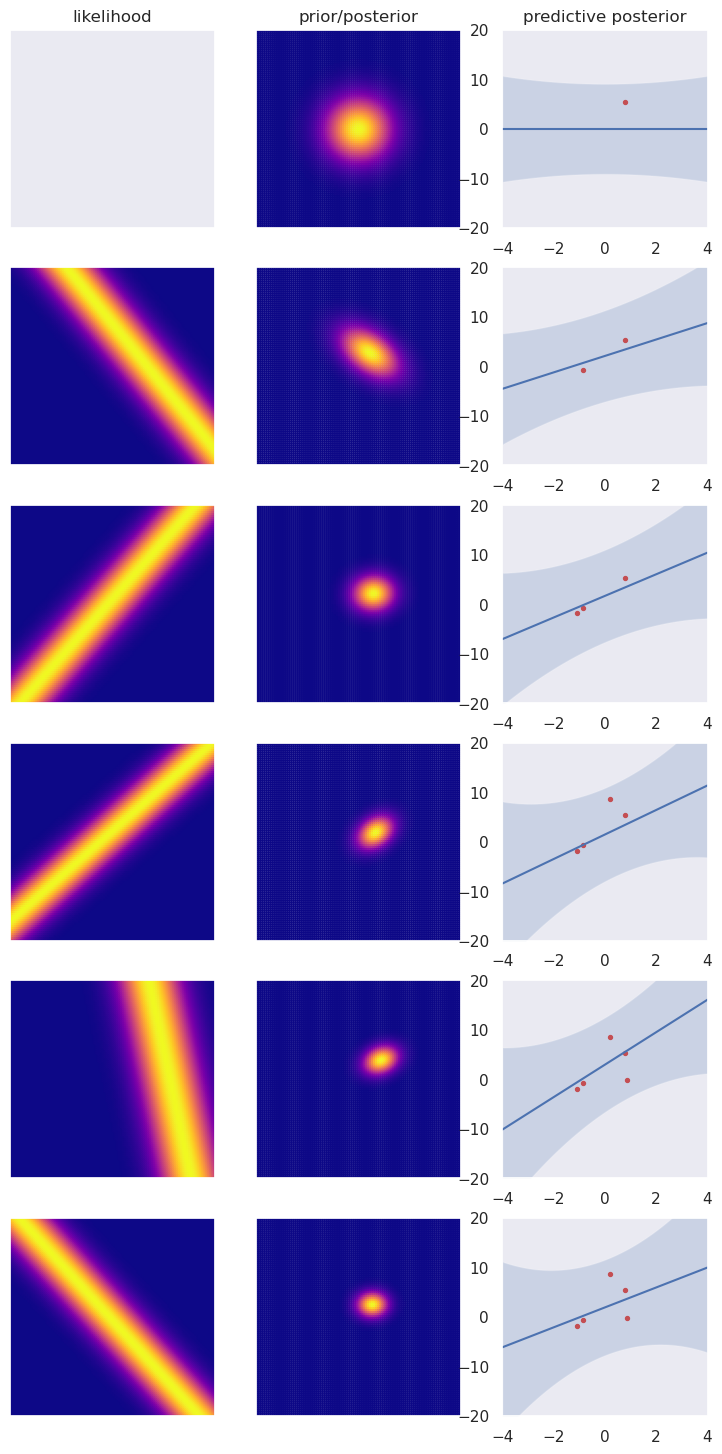

In [14]:
L = len(posterior_sequence)
fig = plt.figure(figsize=(3*3, 3*L))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)

for j, (mu, Q) in enumerate(posterior_sequence):

    # plot likelihood
    ax = fig.add_subplot(L, 3, 3*j+1)
    if j > 0:  # during first round, skip likelihood..
        # define likelihood for x_i
        xi = X[j-1,:]    # i'th example
        yi = y[j-1]      # target value of i'th sample
        plot_likelihood(xi, yi, ax)
    else:
      ax.title.set_text('likelihood')
      ax.axes.xaxis.set_ticklabels([])
      ax.axes.yaxis.set_ticklabels([])


    # plot posterior
    ax = fig.add_subplot(L, 3, 3*j+2)
    if j == 0:
      ax.title.set_text('prior/posterior')
    plot_posterior(mu, Q, ax=ax)

    # plot predictive posterior
    ax = fig.add_subplot(L, 3, 3*j+3)
    if j == 0:
      ax.title.set_text('predictive posterior')
    plot_predictive_posterior(X[:j+1, 1], y[:j+1], mu, Q, a, ax)

